# NLP - Sanskrit

### Understanding Patterns in Gita and Yoga Sutra using Machine Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import tensorflow as tf
import re
import pickle
import statistics
import sentencepiece as spm
import random

from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM ,Embedding,SpatialDropout1D
from tqdm import tqdm
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from numpy.random import permutation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# Data processing and Statistics

In [3]:
# Read data
gita = pd.read_csv('Gita_Verses.csv')
yoga = pd.read_csv('Patanjali_Yoga_Sutras_Verses.csv')

# Encode yoga : 1 and gita :0
gita['encode']='gita'
yoga['encode']='yoga'
gita=gita[["Chapter","Verse","Sanskrit ","encode"]]
yoga=yoga[["Chapter","Verse","Sanskrit ","encode"]]

df = pd.concat([gita,yoga],axis=0,ignore_index=True)

In [4]:
def stats(arr):
    print(f"Count {len(arr)}")
    print(f"mean is {statistics.mean(arr)}")
    print(f"median is {statistics.median(arr)}")
    print(f"mode is {statistics.mode(arr)}")
    print(f"stdev is {statistics.stdev(arr)}")
    print(f"variance is {statistics.variance(arr)}")
    print(f"median_high is {statistics.median_high(arr)}")
    print(f"median_low is {statistics.median_low(arr)}")
    plt.figure(figsize=(3,3))
    plt.hist(arr)
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.show() 

In [5]:
# Gita Verses length
gvl = df[df['encode']=='gita']['Sanskrit '].apply(len).values
# Yoga Verses length
yvl = df[df['encode']=='yoga']['Sanskrit '].apply(len).values

In [6]:
words_dict = dict()
for i in range(len(df)):
    sentence = df['Sanskrit '][i].split()

    for x in sentence:
        if x not in words_dict:
            words_dict[x]=1
        else :
            words_dict[x]+=1


In [7]:
#Top percentile of words are made stopwords
freqs = np.array(list(words_dict.values()))
percentile_val = np.percentile(freqs, 99)

#Identifying and Storing Stopwords
stopwords = list()
for i in words_dict.keys():
    if words_dict[i] > percentile_val:
        stopwords.append(i)

In [8]:
def removeDandas(input_string):
    """
    Removes | or || or ||12.23|| kind of contents in text string
    """
    return re.sub('[|।।]\d+\.\d+[|।।]|[|।।]', '', input_string)

df['Sanskrit ']=df['Sanskrit '].apply(lambda x : removeDandas(x))

In [9]:
segmented_dict = dict()
for i in range(len(df)):
    for j in df['Sanskrit '][i].split():
        if (j not in segmented_dict.keys()) and (j not in stopwords) :
            segmented_dict[j]=df.iloc[i]['encode']

# Dataframe with word-text tagging        
segmented_df = pd.DataFrame(segmented_dict,index=[0])
segmented_df = segmented_df.T.rename(columns={0: 'encode'})
segmented_df= segmented_df.reset_index().rename(columns={'index': 'Sanskrit '})


In [10]:
# Analysis on word length
gsl = segmented_df[segmented_df['encode']=='gita']['Sanskrit '].apply(len).values
ysl = segmented_df[segmented_df['encode']=='yoga']['Sanskrit '].apply(len).values

Count 700
mean is 92
median is 90.0
mode is 88
stdev is 10.295630140987
variance is 106
median_high is 90
median_low is 90


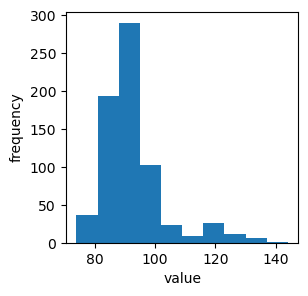

In [11]:
# Gita Verses Stats
stats(gvl)

Count 195
mean is 38
median is 35
mode is 35
stdev is 16.217274740226856
variance is 263
median_high is 35
median_low is 35


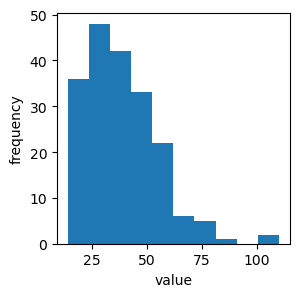

In [12]:
# Yoga Sutra Verses Stats
stats(yvl)

Count 4128
mean is 10
median is 9.0
mode is 6
stdev is 5.5677643628300215
variance is 31
median_high is 9
median_low is 9


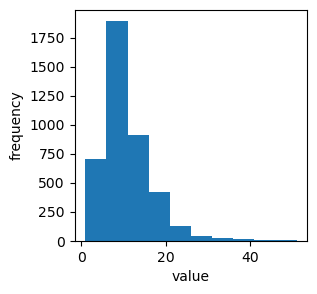

In [13]:
# Gita Segments Stats
stats(gsl)

Count 428
mean is 15
median is 13.0
mode is 10
stdev is 10.295630140987
variance is 106
median_high is 13
median_low is 13


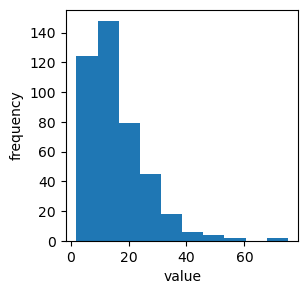

In [14]:
# Yoga Sutra Segments Stats
stats(ysl)

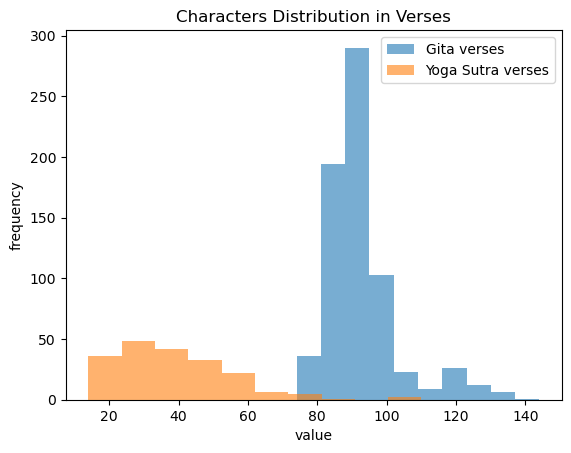

<Figure size 600x600 with 0 Axes>

In [15]:
# Plots on Verses Length
plt.hist(gvl, label='Gita verses', alpha=0.6)
plt.hist(yvl, label='Yoga Sutra verses', alpha=0.6)
plt.legend()
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('Characters Distribution in Verses')
plt.figure(figsize=(6,6))
plt.show() 

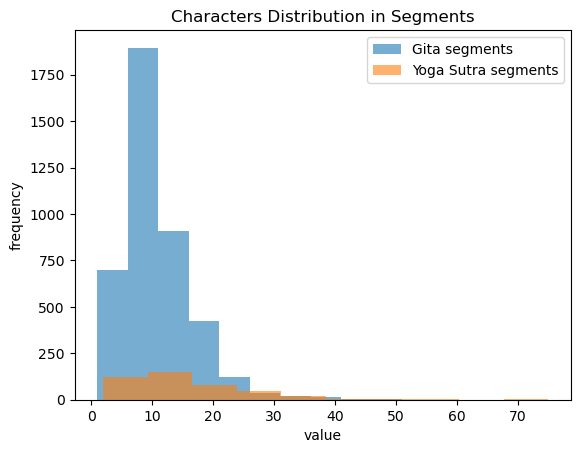

<Figure size 600x600 with 0 Axes>

In [16]:
# Plots on Segment Length

plt.hist(gsl,label='Gita segments', alpha=0.6)
plt.hist(ysl,label='Yoga Sutra segments', alpha=0.6)
plt.title('Characters Distribution in Segments')
plt.legend()
plt.xlabel('value')
plt.ylabel('frequency')
plt.figure(figsize=(6,6))

plt.show() 

In [17]:
# Sanskrit Varnamala
sanskrit_letters = [ 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', '।']
maatras = ['ँ', 'ं', 'ः','़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्',]
letters = [ 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह']

cons = ['क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह']
vow = [ 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ' , "औ" ,"अं" ,"अ:"]

In [18]:
# Collection of right combination of letters and maatras
meaningful_letters = []
for i in cons :
    for j in maatras:
        meaningful_letters.append(i+j)
meaningful_letters =  meaningful_letters + vow

In [19]:
# ENCODING  : Gita 1  : Yoga Sutra 0

VERSES  = df['Sanskrit '].values
ENCODING = np.array([1 if item == 'gita' else 0 for item in df['encode'].values])

VERSES_TRAIN,VERSES_TEST,ENCODING_TRAIN,ENCODING_TEST = train_test_split(VERSES,ENCODING,train_size=0.7,random_state=32)


SEGMENTS  = segmented_df['Sanskrit '].values
ENCODING_SEG = np.array([1 if item == 'gita' else 0 for item in segmented_df['encode'].values])

SEGMENTS_TRAIN,SEGMENTS_TEST,ENCODING_SEG_TRAIN,ENCODING_SEG_TEST = train_test_split(SEGMENTS,ENCODING_SEG,train_size=0.7,random_state=32)

In [20]:
def vowel_count(x):
    c = 0
    for i in x:
        if i in vow:
            c+=1
    return c

In [21]:
def cons_count(x):
    c = 0
    for i in x:
        if i in cons:
            c+=1
    return c

In [22]:
def maatra_count(x):
    c = 0
    for i in x:
        if i in maatras:
            c+=1
    return c

In [23]:
df['maatra_count'] = df['Sanskrit '].apply(maatra_count)
df['cons_count'] = df['Sanskrit '].apply(cons_count)
df['vowel_count'] = df['Sanskrit '].apply(vowel_count)
df['Length']=df['Sanskrit '].apply(len)
df['Num_Words'] = df['Sanskrit '].apply(lambda  x : len(x.split()))

In [24]:
df.groupby('encode').mean()

,Chapter,Verse,maatra_count,cons_count,vowel_count,Length,Num_Words
encode,,,,,,,
gita,9.005714,23.224286,30.774286,42.925714,0.564286,82.855714,9.231429
yoga,2.369231,25.646154,15.364103,21.205128,0.138462,38.343590,2.635897


## Count of Words

In [25]:
gw = df[df['encode']=='gita']['Num_Words']
sw = df[df['encode']=='yoga']['Num_Words']

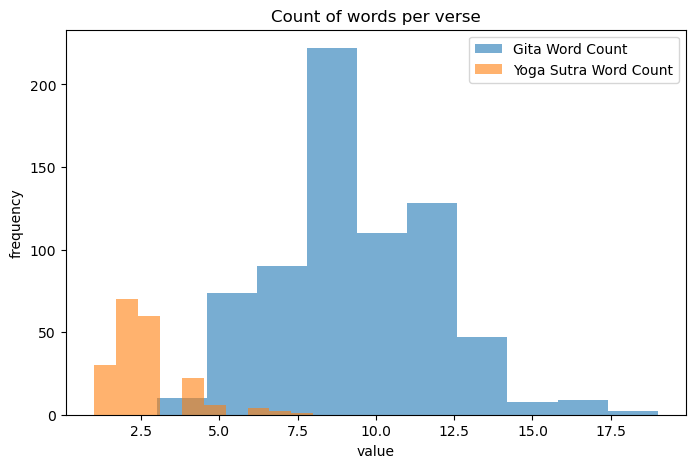

In [26]:
plt.figure(figsize=(8,5))
plt.title('Count of words per verse')
plt.hist(gw,label='Gita Word Count', alpha=0.6)
plt.hist(sw,label='Yoga Sutra Word Count', alpha=0.6)
plt.legend()
plt.xlabel('value')
plt.ylabel('frequency')
plt.show() 

In [27]:
def summary(a):
    """
    Summary on Precision,Recall and F1 score by calcluating True Positive, True Negatives, False Poitives and False Negatives
    """
    TP = a[3]
    FP = a[1]
    FN = a[2]
    TN = a[0]
    def p(a):
        return TP/(TP+FP) 
    def r(a):
        return TP/(TP+FN)
    def f(a):
        return 2*p(a)*r(a)/(p(a)+r(a))

    return p(a),r(a),f(a)


## Logistic Regression

In [28]:
df['encode'] = df['encode'].apply(lambda x: 1 if x=='gita' else 0) 

In [29]:
X = df[['Length', 'Num_Words','maatra_count', 'cons_count', 'vowel_count']]
y = df['encode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=101)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy*100)
accuracy = accuracy_score(y_train,  model.predict(X_train))
print("Train Accuracy:", accuracy*100)

Test Accuracy: 99.0074441687345
Train Accuracy: 98.78048780487805


In [30]:
def run_reg(features):
    """
    Runs logistic regression over certain features 
    Prints Training and Test Accuracy
    Computes the decision boundary
    """
    
    X = df[features]
    y = df['encode']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_train,  model.predict(X_train))
    print("*****************\nLogistic regression with features ",features)

    print("Train Accuracy:", accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", accuracy)
    
    print("Decision boundary ",(-model.intercept_/model.coef_)[0][0])
    print("*****************\n")

In [31]:
features = ['Length', 'Num_Words','maatra_count', 'cons_count', 'vowel_count']
def select(arr,i):
    s= []
    for j in i:
        s.append(arr[j])
    return s
def remove(arr,i):
    s= []
    for j in range(len(arr)):
        if j not in i:
            s.append(arr[j])
    return s

### Logistic Regression with all features taken 1 at a time

In [32]:
for i in range(len(features)):
    run_reg(select(features,[i]))

*****************
Logistic regression with features  ['Length']
Train Accuracy: 0.9856230031948882
Test Accuracy: 0.9851301115241635
Decision boundary  62.2143974343308
*****************

*****************
Logistic regression with features  ['Num_Words']
Train Accuracy: 0.9680511182108626
Test Accuracy: 0.9888475836431226
Decision boundary  4.607840853903192
*****************

*****************
Logistic regression with features  ['maatra_count']
Train Accuracy: 0.9680511182108626
Test Accuracy: 0.9591078066914498
Decision boundary  21.54429926791077
*****************

*****************
Logistic regression with features  ['cons_count']
Train Accuracy: 0.9792332268370607
Test Accuracy: 0.9814126394052045
Decision boundary  32.716651521434336
*****************

*****************
Logistic regression with features  ['vowel_count']
Train Accuracy: 0.7843450479233227
Test Accuracy: 0.7769516728624535
Decision boundary  -0.598264885663602
*****************



In [33]:
df = pd.concat([gita,yoga],axis=0,ignore_index=True)

# Probability Model

In [34]:
# Creating Frequency Distribution

def build_frequency_distbn(df):
    gita_all_string = ""
    for i in segmented_df[segmented_df['encode']=='gita']['Sanskrit '].values:
        gita_all_string+=i
    sutra_all_string = ""
    for i in segmented_df[segmented_df['encode']=='yoga']['Sanskrit '].values:
        sutra_all_string+=i
        
        gita_two_letter_dict = dict()
    sutra_two_letter_dict = dict()
    
    for i in range(len(gita_all_string)):
        try:
            x = gita_all_string[i]+gita_all_string[i+1]
            if x not in gita_two_letter_dict:
                gita_two_letter_dict[x] = 1
            else:
                gita_two_letter_dict[x] += 1
        except:
            print("*")
        
    for i in range(len(sutra_all_string)):
        try:
            x = sutra_all_string[i]+sutra_all_string[i+1]
            if x not in sutra_two_letter_dict:
                sutra_two_letter_dict[x] = 1
            else:
                sutra_two_letter_dict[x] += 1
        except:
            print("**")
            
    for key, value in gita_two_letter_dict.items():
        if key not in sutra_two_letter_dict:
            sutra_two_letter_dict[key]=.1
        
    for key, value in sutra_two_letter_dict.items():
        if key not in gita_two_letter_dict:
            gita_two_letter_dict[key]=0.1

    total = sum(gita_two_letter_dict.values())
    gita_two_letter_dict = {key: (value) / total for key, value in gita_two_letter_dict.items()}
    
    total = sum(sutra_two_letter_dict.values())
    sutra_two_letter_dict = {key: (value) / total for key, value in sutra_two_letter_dict.items()}

    return gita_two_letter_dict,sutra_two_letter_dict

gita_two_letter_dict,sutra_two_letter_dict = build_frequency_distbn(df)

*
**


In [35]:
def predict_probability(gita,sutra,word):
    p_gita = 1
    p_sutra = -1
    
    for i in range(len(word)):
        try:
             p_gita = p_gita*gita[word[i]+word[i+1]]
        except:
             p_gita*=1
                
    for i in range(len(word)):
        try:
             p_sutra = abs(p_sutra*sutra[word[i]+word[i+1]])
        except:
             p_sutra*=1
    
    if p_gita>p_sutra :
        return "gita"
    else:
        return "yoga"

# Sample Prediction
predict_probability(gita_two_letter_dict,sutra_two_letter_dict,"अत्रमहेष्वासा भीमार्जुनसमा युधि युयुधानो.य")

'gita'

## Probability Model Predictions

In [36]:
def predict_prob_all(df,gita_two_letter_dict,sutra_two_letter_dict,num=1):
    """
    
    Predicts the accuracy over the dataset fed taking each data point at a time when num=1
    
    For a given value of num , It computes the accuracy over the dataset fed taking 19 - num 
    number of words at a time for each datapoint
    
    """
    results = []
    dataframe = []
    
    for z in range(num):
        n=19-z
        checked = []
        y_true_list = []
        y_predicted_list = []

        for i in ((range(len(df['Sanskrit '].values)))):
            word = df['Sanskrit '].values[i]

            if(len(word.split())<=n):
                t = word.split()
                if ' '.join(t) not in checked:
                    checked.append(' '.join(t))
                    if predict_probability(gita_two_letter_dict,sutra_two_letter_dict,' '.join(t))== 'gita' :
                        y_predicted = 1
                        y_predicted_list.append(1)
                    else:
                        y_predicted = 0
                        y_predicted_list.append(0)

                    if df['encode'].values[i] == 'gita':
                        y_true = 1

                        y_true_list.append(1)
                    else:

                        y_true = 0
                        y_true_list.append(0)  
                    continue    
            else:    
                for k in range(len(word.split())):
                    if len(word.split()[k:k+n])==n:
                            t =word.split()[k:k+n]
                            if ' '.join(t) not in checked:
                                checked.append(' '.join(t))
                                if predict_probability(gita_two_letter_dict,sutra_two_letter_dict,' '.join(t))== 'gita' :
                                    y_predicted = 1
                                    y_predicted_list.append(1)
                                else:
                                    y_predicted = 0
                                    y_predicted_list.append(0)
                                if df['encode'].values[i] == 'gita':
                                    y_true = 1
                                    y_true_list.append(1)
                                else:
                                    y_true = 0
                                    y_true_list.append(0) 




        correct= sum(np.array(y_predicted_list) == np.array(y_true_list))

        accuracy = correct/len(y_true_list)
        results.append(f"Accuracy for max of {n} words taken at a time using Sentencepiece tokenizer + ANN is : {accuracy*100}")
        print(f"Accuracy for max of {n} words taken at a time is : {accuracy*100}")
        TN = sum([y_true_list[x] == 0 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
        FP = sum([y_true_list[x] == 0 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
        TP = sum([y_true_list[x] == 1 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
        FN = sum([y_true_list[x] == 1 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
        P,R,F = summary([TN,FP,FN,TP])
        dataframe.append({"Number" : n,"Accuracy": accuracy*100,"TN" :TN ,"TP": TP ,"FN": FN ,"FP": FP , "Precision": P , "Recall": R , "F1": F })
    return pd.DataFrame(dataframe)

### Accuracy of 1-19 words taken at a time from each verse 

In [37]:
predict_prob_all(df,gita_two_letter_dict,sutra_two_letter_dict,num=19)

Accuracy for max of 19 words taken at a time is : 97.6536312849162
Accuracy for max of 18 words taken at a time is : 97.65625
Accuracy for max of 17 words taken at a time is : 97.66146993318485
Accuracy for max of 16 words taken at a time is : 97.67184035476718
Accuracy for max of 15 words taken at a time is : 97.69989047097481
Accuracy for max of 14 words taken at a time is : 97.63948497854076
Accuracy for max of 13 words taken at a time is : 97.73429454170957
Accuracy for max of 12 words taken at a time is : 97.6878612716763
Accuracy for max of 11 words taken at a time is : 97.75474956822107
Accuracy for max of 10 words taken at a time is : 97.8629329403095
Accuracy for max of 9 words taken at a time is : 97.84560143626571
Accuracy for max of 8 words taken at a time is : 97.51671442215854
Accuracy for max of 7 words taken at a time is : 96.57403882755995
Accuracy for max of 6 words taken at a time is : 96.02954755309327
Accuracy for max of 5 words taken at a time is : 94.416114227434

,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,97.653631,184,690,10,11,0.984308,0.985714,0.985011
1,18,97.656250,184,691,10,11,0.984330,0.985735,0.985032
2,17,97.661470,184,693,10,11,0.984375,0.985775,0.985075
3,16,97.671840,184,697,10,11,0.984463,0.985856,0.985159
4,15,97.699890,184,708,10,11,0.984701,0.986072,0.985386
5,14,97.639485,184,726,11,11,0.985075,0.985075,0.985075
6,13,97.734295,184,765,11,11,0.985825,0.985825,0.985825
7,12,97.687861,184,830,13,11,0.986920,0.984579,0.985748
8,11,97.754750,184,948,15,11,0.988530,0.984424,0.986472
9,10,97.862933,184,1144,18,11,0.990476,0.984509,0.987484


# Probability Model 
Split of 70 : 30 in Training and Testing

In [38]:
def return_segmented_df(df):
    segmented_dict = dict()
    for i in range(len(df)):
        for j in df['Sanskrit '][i].split():
            if (j not in segmented_dict.keys()) and (j not in stopwords) :
                segmented_dict[j]=df.iloc[i]['encode']
                
    segmented_df = pd.DataFrame(segmented_dict,index=[0])
    segmented_df = segmented_df.T.rename(columns={0: 'encode'})
    segmented_df= segmented_df.reset_index().rename(columns={'index': 'Sanskrit '})
    return segmented_df

partial_df = permutation(df[['Sanskrit ','encode']])
small_df_train = pd.DataFrame(partial_df,columns=['Sanskrit ','encode'])[:int(0.7*len(partial_df))]
small_df_test = pd.DataFrame(partial_df,columns=['Sanskrit ','encode'])[int(0.7*len(partial_df)):]
small_df_train_segmented = return_segmented_df(small_df_train)

In [39]:
gita_two_letter_dict,sutra_two_letter_dict = build_frequency_distbn(small_df_train_segmented)

*
**


## Train and Test results 

#### Accuracy with training data (70% of verses)


In [40]:
predict_prob_all(small_df_train,gita_two_letter_dict,sutra_two_letter_dict)

Accuracy for max of 19 words taken at a time is : 98.08306709265176


,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,98.083067,125,489,5,7,0.985887,0.989879,0.987879


#### Accuracy with training data (segments from this 70% verses) : 


In [41]:
predict_prob_all(return_segmented_df(small_df_train),gita_two_letter_dict,sutra_two_letter_dict)

Accuracy for max of 19 words taken at a time is : 79.77433004231311


,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,79.77433,258,2570,678,39,0.985052,0.791256,0.877582


#### Accuracy with test data (the other 30% of verses) :

In [42]:
predict_prob_all(small_df_test,gita_two_letter_dict,sutra_two_letter_dict)

Accuracy for max of 19 words taken at a time is : 96.6542750929368


,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,96.654275,59,201,5,4,0.980488,0.975728,0.978102


#### Accuracy with test data (segments from the other 30% of verses) : 


In [43]:
small_df_test = small_df_test.reset_index()[['Sanskrit ','encode']]
predict_prob_all(return_segmented_df(small_df_test),gita_two_letter_dict,sutra_two_letter_dict)

Accuracy for max of 19 words taken at a time is : 78.47394540942928


,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,78.473945,126,1139,324,23,0.980207,0.778537,0.86781


#### Accuracy with the entire dataset (verses)


In [44]:
predict_prob_all(df,gita_two_letter_dict,sutra_two_letter_dict)

Accuracy for max of 19 words taken at a time is : 97.6536312849162


,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,97.653631,184,690,10,11,0.984308,0.985714,0.985011


#### Accuracy with the entire dataset (segments)


In [45]:
predict_prob_all(return_segmented_df(df),gita_two_letter_dict,sutra_two_letter_dict)

Accuracy for max of 19 words taken at a time is : 79.6243364638628


,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,79.624336,374,3526,942,56,0.984366,0.789167,0.876025


## ANN Model 

In [38]:

tokenizer = Tokenizer(num_words=5000, split=' ',oov_token="OOV") 
tokenizer.fit_on_texts(df['Sanskrit '].values)
X = tokenizer.texts_to_sequences(df['Sanskrit '].values)
X = pad_sequences(X,maxlen=20)
Y = pd.get_dummies(df['encode'])

x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.7,random_state=32)

In [39]:
model1 = Sequential()
model1.add(Embedding(5000, 120, input_length = x_train.shape[1]))
model1.add(SpatialDropout1D(0.4))
model1.add(LSTM(500, dropout=0.4, recurrent_dropout=0.4))
model1.add(Dense(300, activation='LeakyReLU'))
model1.add(Dense(150, activation='LeakyReLU'))
model1.add(Dense(2,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [40]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 120)           600000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 120)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 500)               1242000   
                                                                 
 dense (Dense)               (None, 300)               150300    
                                                                 
 dense_1 (Dense)             (None, 150)               45150     
                                                                 
 dense_2 (Dense)             (None, 2)                 302       
                                                        

In [41]:
def print_summary(model):
    """
    Prints the Summary of model
    """
    summary_data = []
    
    for layer in model.layers:
        layer_name = layer.__class__.__name__
        output_shape = layer.output_shape[1:]  
        num_params = layer.count_params()
        summary_data.append([layer_name, output_shape, num_params])
    
    headers = ["Layer (type)", "Output Shape", "Param #"]
    return pd.DataFrame(summary_data, columns=["Layer (type)", "Output Shape", "Param #"])


In [42]:
print_summary(model1)

,Layer (type),Output Shape,Param #
0,Embedding,"(20, 120)",600000
1,SpatialDropout1D,"(20, 120)",0
2,LSTM,"(500,)",1242000
3,Dense,"(300,)",150300
4,Dense,"(150,)",45150
5,Dense,"(2,)",302


In [44]:
history1  = model1.fit(x_train, y_train, epochs = 10, batch_size=32, verbose =1)


Epoch 1/10
20/20 [==============================] - 19s 344ms/step - loss: 0.3126 - accuracy: 0.8930
Epoch 2/10
20/20 [==============================] - 7s 339ms/step - loss: 0.0581 - accuracy: 0.9824
Epoch 3/10
20/20 [==============================] - 7s 345ms/step - loss: 0.0152 - accuracy: 0.9952
Epoch 4/10
20/20 [==============================] - 7s 349ms/step - loss: 0.0117 - accuracy: 0.9968
Epoch 5/10
20/20 [==============================] - 7s 351ms/step - loss: 0.0027 - accuracy: 0.9984
Epoch 6/10
20/20 [==============================] - 8s 407ms/step - loss: 9.1109e-04 - accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 10s 530ms/step - loss: 3.1353e-04 - accuracy: 1.0000
Epoch 8/10
20/20 [==============================] - 8s 400ms/step - loss: 7.1154e-05 - accuracy: 1.0000
Epoch 9/10
20/20 [==============================] - 7s 356ms/step - loss: 5.6727e-05 - accuracy: 1.0000
Epoch 10/10
20/20 [==============================] - 7s 363ms/step - loss: 8.7845e

## Confusion Matrix

TRAIN Accuracy: 100 %
TEST Accuracy : 94.42379182156134 %
Confusion matrix


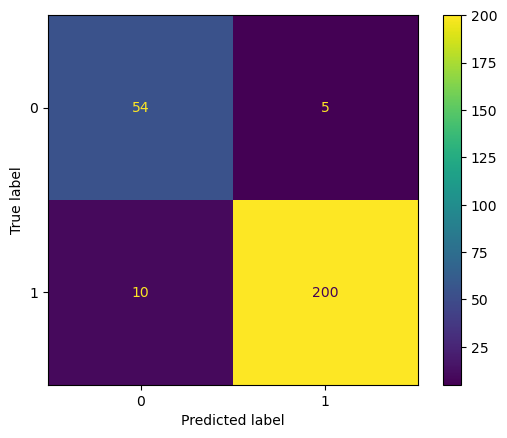

In [45]:
predicted  = [np.argmax(model1.predict(pad_sequences(tokenizer.texts_to_sequences([x]),maxlen=20),verbose=0)) for x in VERSES_TEST]
actual = ENCODING_TEST
# Due to argmax encoding is inverted
print("TRAIN Accuracy: 100 %")
print(f"TEST Accuracy : {(sum(actual!=predicted)*100/len(ENCODING_TEST))} %")
print("Confusion matrix")
classes  = ['Yoga','Gita']
invert = [1 if x==0 else 0 for x in predicted]
cm = confusion_matrix(ENCODING_TEST, invert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

# ANN model with Sentencepiece tokenizer

In [46]:
spm.SentencePieceTrainer.train(input='data.txt', model_prefix='sentence', vocab_size=1000, user_defined_symbols=['foo', 'bar'])

sp = spm.SentencePieceProcessor(model_file='sentence.model')
sp

<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x000002889B9FE5D0> >

In [47]:
def pad_arrays(arr):
    max_length = 140
    padded_arr = []
    for subarr in arr:
        num_zeros = max_length - len(subarr)
        padded_subarr = [0] * num_zeros + subarr
        padded_arr.append(padded_subarr)
    return padded_arr


In [48]:
def pad_arrays_maxlen(arr,t):

    max_length = -1
    for i in arr:
        if(len(i) > max_length):
            max_length=len(i)
    if(t):
        max_length=t
    padded_arr = []
    for subarr in arr:
        num_zeros = max_length - len(subarr)
        padded_subarr = [0] * num_zeros + subarr
        padded_arr.append(padded_subarr)
        
    return padded_arr


In [49]:
X = [sp.encode(df['Sanskrit '][x]) for x in range(len(df))]
X =  np.array(pad_arrays(X))

Y = np.array([1 if item == 'gita' else 0 for item in df['encode'].values])
Counter(Y)
Y = Y.reshape(-1,1)

x_train,x_test,y_train,y_test = train_test_split(np.array(X),Y,train_size=0.7,random_state=32)

model2 = Sequential()
model2.add(Embedding(1000, 120, input_length = 140))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(256, activation='LeakyReLU'))
model2.add(Dense(128, activation='LeakyReLU'))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [50]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 120)          120000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 140, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 512)               1296384   
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

In [51]:
print_summary(model2)

,Layer (type),Output Shape,Param #
0,Embedding,"(140, 120)",120000
1,SpatialDropout1D,"(140, 120)",0
2,LSTM,"(512,)",1296384
3,Dense,"(256,)",131328
4,Dense,"(128,)",32896
5,Dense,"(1,)",129


In [53]:
history2  = model2.fit(x_train, y_train, epochs = 20, batch_size=32, verbose =1)

Epoch 1/20
20/20 [==============================] - 63s 3s/step - loss: 0.5065 - accuracy: 0.8147
Epoch 2/20
20/20 [==============================] - 48s 2s/step - loss: 0.9687 - accuracy: 0.8259
Epoch 3/20
20/20 [==============================] - 52s 3s/step - loss: 0.2684 - accuracy: 0.9010
Epoch 4/20
20/20 [==============================] - 49s 2s/step - loss: 0.0643 - accuracy: 0.9968
Epoch 5/20
20/20 [==============================] - 49s 2s/step - loss: 0.0075 - accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 52s 3s/step - loss: 0.0026 - accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 50s 2s/step - loss: 0.0012 - accuracy: 1.0000
Epoch 8/20
20/20 [==============================] - 35s 2s/step - loss: 6.9874e-04 - accuracy: 1.0000
Epoch 9/20
20/20 [==============================] - 34s 2s/step - loss: 5.3773e-04 - accuracy: 1.0000
Epoch 10/20
20/20 [==============================] - 33s 2s/step - loss: 4.5336e-04 - accuracy: 1.0000
Epoch 1

## Confusion Matrix

28/28 [==============================] - 16s 253ms/step
Confusion matrix


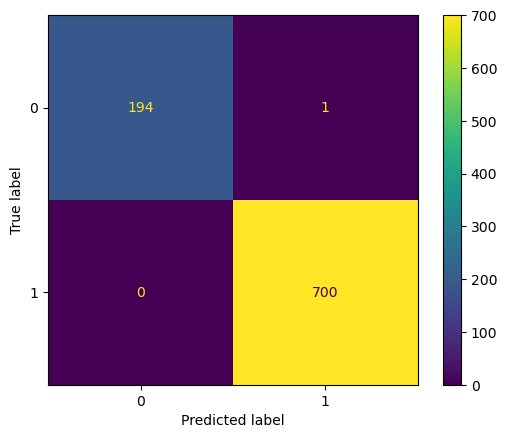

In [54]:
predicted_ss = [1 if x > 0.5 else 0 for x in model2.predict(X)]

print("Confusion matrix")
classes  = ['Yoga','Gita']
cm = confusion_matrix(Y, predicted_ss)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

## Prediction with 1-19 words taken at a time from each verse

In [55]:
dataframe = []
results = []
for z in range(19):
    checked = []
    dummy = []
    y_true_list = []
    y_predicted_list=[]
    n = 19-z
    query = []
    for i in tqdm(range(len(df))):
        word = df['Sanskrit '].values[i]
        if len(word.split()) <= n:
            t = word.split()
            if ' '.join(t) not in checked:
                checked.append(' '.join(t))
                dummy.append(permutation(t))
                query.append(  np.array(pad_arrays_maxlen([sp.encode(' '.join((t)))],140)).reshape(1,140)  )
                if df['encode'].values[i] == 'gita':
                    y_true = 1
                    y_true_list.append(1)
                    
                else:
                    
                    y_true = 0
                    y_true_list.append(0)  
                
        else:
            for k in range(len(word.split())):
                if len(word.split()[k:k+n]) == n:
                    t = word.split()[k:k+n]
                    if ' '.join(t) not in checked:
                        checked.append(' '.join(t))
                        dummy.append(permutation(t))
                        query.append(  np.array(pad_arrays_maxlen([sp.encode(' '.join((t)))],140)).reshape(1,140)  )
                        if df['encode'].values[i] == 'gita':
                            y_true = 1
                            y_true_list.append(1)
                        else:
                            y_true = 0
                            y_true_list.append(0)  
                          
    
    y_predicted_list = model2.predict(np.array(query).reshape(np.array(query).shape[0],140))

    y_predicted_list[y_predicted_list >=0.5]=1
    y_predicted_list[y_predicted_list < 0.5]=0
    correct= sum(np.array(y_predicted_list.reshape(-1)) == np.array(y_true_list))
    y_predicted_list =  y_predicted_list.reshape(-1)
    accuracy = correct/len(y_true_list)
    results.append(f"Accuracy for max of {n} words taken at a time using Sentencepiece tokenizer + ANN is : {accuracy*100}")
    print(f"Accuracy for max of {n} words taken at a time is : {accuracy*100}")
    TN = sum([y_true_list[x] == 0 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
    FP = sum([y_true_list[x] == 0 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
    TP = sum([y_true_list[x] == 1 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
    FN = sum([y_true_list[x] == 1 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
    P,R,F = summary([TN,FP,FN,TP])
    dataframe.append({"Number" : n,"Accuracy": accuracy*100,"TN" :TN ,"TP": TP ,"FN": FN ,"FP": FP , "Precision": P , "Recall": R , "F1": F })
    print(pd.DataFrame(dataframe))

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 888.54it/s]


28/28 [==============================] - 7s 231ms/step
Accuracy for max of 19 words taken at a time is : 99.88826815642457
   Number   Accuracy   TN   TP  FN  FP  Precision  Recall        F1
0      19  99.888268  194  700   0   1   0.998573     1.0  0.999286


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 5090.87it/s]


28/28 [==============================] - 7s 243ms/step
Accuracy for max of 18 words taken at a time is : 99.88839285714286
   Number   Accuracy   TN   TP  FN  FP  Precision  Recall        F1
0      19  99.888268  194  700   0   1   0.998573     1.0  0.999286
1      18  99.888393  194  701   0   1   0.998575     1.0  0.999287


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 4149.41it/s]


29/29 [==============================] - 7s 236ms/step
Accuracy for max of 17 words taken at a time is : 99.88864142538975
   Number   Accuracy   TN   TP  FN  FP  Precision  Recall        F1
0      19  99.888268  194  700   0   1   0.998573     1.0  0.999286
1      18  99.888393  194  701   0   1   0.998575     1.0  0.999287
2      17  99.888641  194  703   0   1   0.998580     1.0  0.999289


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 7668.60it/s]


29/29 [==============================] - 7s 246ms/step
Accuracy for max of 16 words taken at a time is : 99.88913525498891
   Number   Accuracy   TN   TP  FN  FP  Precision  Recall        F1
0      19  99.888268  194  700   0   1   0.998573     1.0  0.999286
1      18  99.888393  194  701   0   1   0.998575     1.0  0.999287
2      17  99.888641  194  703   0   1   0.998580     1.0  0.999289
3      16  99.889135  194  707   0   1   0.998588     1.0  0.999293


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 7696.19it/s]


29/29 [==============================] - 7s 238ms/step
Accuracy for max of 15 words taken at a time is : 99.67141292442497
   Number   Accuracy   TN   TP  FN  FP  Precision    Recall        F1
0      19  99.888268  194  700   0   1   0.998573  1.000000  0.999286
1      18  99.888393  194  701   0   1   0.998575  1.000000  0.999287
2      17  99.888641  194  703   0   1   0.998580  1.000000  0.999289
3      16  99.889135  194  707   0   1   0.998588  1.000000  0.999293
4      15  99.671413  194  716   2   1   0.998605  0.997214  0.997909


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 4624.22it/s]


30/30 [==============================] - 7s 242ms/step
Accuracy for max of 14 words taken at a time is : 99.0343347639485
   Number   Accuracy   TN   TP  FN  FP  Precision    Recall        F1
0      19  99.888268  194  700   0   1   0.998573  1.000000  0.999286
1      18  99.888393  194  701   0   1   0.998575  1.000000  0.999287
2      17  99.888641  194  703   0   1   0.998580  1.000000  0.999289
3      16  99.889135  194  707   0   1   0.998588  1.000000  0.999293
4      15  99.671413  194  716   2   1   0.998605  0.997214  0.997909
5      14  99.034335  194  729   8   1   0.998630  0.989145  0.993865


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 6900.66it/s]


31/31 [==============================] - 7s 233ms/step
Accuracy for max of 13 words taken at a time is : 97.52832131822863
   Number   Accuracy   TN   TP  FN  FP  Precision    Recall        F1
0      19  99.888268  194  700   0   1   0.998573  1.000000  0.999286
1      18  99.888393  194  701   0   1   0.998575  1.000000  0.999287
2      17  99.888641  194  703   0   1   0.998580  1.000000  0.999289
3      16  99.889135  194  707   0   1   0.998588  1.000000  0.999293
4      15  99.671413  194  716   2   1   0.998605  0.997214  0.997909
5      14  99.034335  194  729   8   1   0.998630  0.989145  0.993865
6      13  97.528321  194  753  23   1   0.998674  0.970361  0.984314


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 6750.02it/s]


33/33 [==============================] - 8s 238ms/step
Accuracy for max of 12 words taken at a time is : 94.21965317919076
   Number   Accuracy   TN   TP  FN  FP  Precision    Recall        F1
0      19  99.888268  194  700   0   1   0.998573  1.000000  0.999286
1      18  99.888393  194  701   0   1   0.998575  1.000000  0.999287
2      17  99.888641  194  703   0   1   0.998580  1.000000  0.999289
3      16  99.889135  194  707   0   1   0.998588  1.000000  0.999293
4      15  99.671413  194  716   2   1   0.998605  0.997214  0.997909
5      14  99.034335  194  729   8   1   0.998630  0.989145  0.993865
6      13  97.528321  194  753  23   1   0.998674  0.970361  0.984314
7      12  94.219653  194  784  59   1   0.998726  0.930012  0.963145


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 2749.96it/s]


37/37 [==============================] - 8s 222ms/step
Accuracy for max of 11 words taken at a time is : 89.11917098445595
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  99.888268  194  700    0   1   0.998573  1.000000  0.999286
1      18  99.888393  194  701    0   1   0.998575  1.000000  0.999287
2      17  99.888641  194  703    0   1   0.998580  1.000000  0.999289
3      16  99.889135  194  707    0   1   0.998588  1.000000  0.999293
4      15  99.671413  194  716    2   1   0.998605  0.997214  0.997909
5      14  99.034335  194  729    8   1   0.998630  0.989145  0.993865
6      13  97.528321  194  753   23   1   0.998674  0.970361  0.984314
7      12  94.219653  194  784   59   1   0.998726  0.930012  0.963145
8      11  89.119171  194  838  125   1   0.998808  0.870197  0.930078


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 3918.51it/s]


43/43 [==============================] - 11s 240ms/step
Accuracy for max of 10 words taken at a time is : 80.32424465733236
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  99.888268  194  700    0   1   0.998573  1.000000  0.999286
1      18  99.888393  194  701    0   1   0.998575  1.000000  0.999287
2      17  99.888641  194  703    0   1   0.998580  1.000000  0.999289
3      16  99.889135  194  707    0   1   0.998588  1.000000  0.999293
4      15  99.671413  194  716    2   1   0.998605  0.997214  0.997909
5      14  99.034335  194  729    8   1   0.998630  0.989145  0.993865
6      13  97.528321  194  753   23   1   0.998674  0.970361  0.984314
7      12  94.219653  194  784   59   1   0.998726  0.930012  0.963145
8      11  89.119171  194  838  125   1   0.998808  0.870197  0.930078
9      10  80.324245  194  896  266   1   0.998885  0.771084  0.870325


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 2788.08it/s]


53/53 [==============================] - 15s 271ms/step
Accuracy for max of 9 words taken at a time is : 69.4195092758827
    Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0       19  99.888268  194  700    0   1   0.998573  1.000000  0.999286
1       18  99.888393  194  701    0   1   0.998575  1.000000  0.999287
2       17  99.888641  194  703    0   1   0.998580  1.000000  0.999289
3       16  99.889135  194  707    0   1   0.998588  1.000000  0.999293
4       15  99.671413  194  716    2   1   0.998605  0.997214  0.997909
5       14  99.034335  194  729    8   1   0.998630  0.989145  0.993865
6       13  97.528321  194  753   23   1   0.998674  0.970361  0.984314
7       12  94.219653  194  784   59   1   0.998726  0.930012  0.963145
8       11  89.119171  194  838  125   1   0.998808  0.870197  0.930078
9       10  80.324245  194  896  266   1   0.998885  0.771084  0.870325
10       9  69.419509  194  966  510   1   0.998966  0.654472  0.790831


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 2454.45it/s]


66/66 [==============================] - 17s 262ms/step
Accuracy for max of 8 words taken at a time is : 58.78701050620821
    Number   Accuracy   TN    TP   FN  FP  Precision    Recall        F1
0       19  99.888268  194   700    0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701    0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703    0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707    0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716    2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729    8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753   23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784   59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838  125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896  266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966  510   1   0.998966  0.654472  0.790831
1

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1676.69it/s]


83/83 [==============================] - 23s 271ms/step
Accuracy for max of 7 words taken at a time is : 49.143509706889986
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  99.888268  194   700     0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701     0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703     0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707     0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716     2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729     8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753    23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784    59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838   125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896   266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966   510   1   0.998966  0.65447

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1722.86it/s]


102/102 [==============================] - 24s 239ms/step
Accuracy for max of 6 words taken at a time is : 41.85903354878424
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  99.888268  194   700     0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701     0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703     0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707     0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716     2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729     8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753    23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784    59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838   125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896   266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966   510   1   0.998966  0.6544

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1342.49it/s]


123/123 [==============================] - 36s 289ms/step
Accuracy for max of 5 words taken at a time is : 36.69046404895461
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  99.888268  194   700     0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701     0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703     0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707     0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716     2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729     8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753    23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784    59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838   125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896   266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966   510   1   0.998966  0.6544

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 972.47it/s]


145/145 [==============================] - 38s 264ms/step
Accuracy for max of 4 words taken at a time is : 30.093093743234466
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  99.888268  194   700     0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701     0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703     0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707     0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716     2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729     8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753    23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784    59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838   125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896   266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966   510   1   0.998966  0.654

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 811.62it/s]


167/167 [==============================] - 48s 289ms/step
Accuracy for max of 3 words taken at a time is : 21.269006945748075
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  99.888268  194   700     0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701     0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703     0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707     0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716     2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729     8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753    23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784    59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838   125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896   266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966   510   1   0.998966  0.654

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 662.03it/s]


186/186 [==============================] - 54s 287ms/step
Accuracy for max of 2 words taken at a time is : 13.757147662293978
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  99.888268  194   700     0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701     0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703     0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707     0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716     2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729     8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753    23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784    59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838   125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896   266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966   510   1   0.998966  0.654

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1381.42it/s]


155/155 [==============================] - 38s 245ms/step
Accuracy for max of 1 words taken at a time is : 19.23932834311147
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  99.888268  194   700     0   1   0.998573  1.000000  0.999286
1       18  99.888393  194   701     0   1   0.998575  1.000000  0.999287
2       17  99.888641  194   703     0   1   0.998580  1.000000  0.999289
3       16  99.889135  194   707     0   1   0.998588  1.000000  0.999293
4       15  99.671413  194   716     2   1   0.998605  0.997214  0.997909
5       14  99.034335  194   729     8   1   0.998630  0.989145  0.993865
6       13  97.528321  194   753    23   1   0.998674  0.970361  0.984314
7       12  94.219653  194   784    59   1   0.998726  0.930012  0.963145
8       11  89.119171  194   838   125   1   0.998808  0.870197  0.930078
9       10  80.324245  194   896   266   1   0.998885  0.771084  0.870325
10       9  69.419509  194   966   510   1   0.998966  0.6544

In [56]:
pd.DataFrame(dataframe)

,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,99.888268,194,700,0,1,0.998573,1.000000,0.999286
1,18,99.888393,194,701,0,1,0.998575,1.000000,0.999287
2,17,99.888641,194,703,0,1,0.998580,1.000000,0.999289
3,16,99.889135,194,707,0,1,0.998588,1.000000,0.999293
4,15,99.671413,194,716,2,1,0.998605,0.997214,0.997909
5,14,99.034335,194,729,8,1,0.998630,0.989145,0.993865
6,13,97.528321,194,753,23,1,0.998674,0.970361,0.984314
7,12,94.219653,194,784,59,1,0.998726,0.930012,0.963145
8,11,89.119171,194,838,125,1,0.998808,0.870197,0.930078
9,10,80.324245,194,896,266,1,0.998885,0.771084,0.870325


## Word input in random order

In [57]:
# random word order input 
dataframe = []
results = []
for z in range(19):
    checked = []
    dummy = []
    y_true_list = []
    y_predicted_list=[]
    n = 19-z
    query = []
    for i in tqdm(range(len(df))):
        word = df['Sanskrit '].values[i]
        if len(word.split()) <= n:
            t = word.split()
            if ' '.join(t) not in checked:
                checked.append(' '.join(t))
                dummy.append(permutation(t))
                query.append(  np.array(pad_arrays_maxlen([sp.encode(' '.join(permutation(t)))],140)).reshape(1,140)  )
                if df['encode'].values[i] == 'gita':
                    y_true = 1
                    y_true_list.append(1)
                    
                else:
                    
                    y_true = 0
                    y_true_list.append(0)  
                
        else:
            for k in range(len(word.split())):
                if len(word.split()[k:k+n]) == n:
                    t = word.split()[k:k+n]
                    if ' '.join(t) not in checked:
                        checked.append(' '.join(t))
                        dummy.append(permutation(t))
                        query.append(  np.array(pad_arrays_maxlen([sp.encode(' '.join(permutation(t)))],140)).reshape(1,140)  )
                        if df['encode'].values[i] == 'gita':
                            y_true = 1
                            y_true_list.append(1)
                        else:
                            y_true = 0
                            y_true_list.append(0)  
                          
    
    y_predicted_list = model2.predict(np.array(query).reshape(np.array(query).shape[0],140))

    y_predicted_list[y_predicted_list >=0.5]=1
    y_predicted_list[y_predicted_list < 0.5]=0
    correct= sum(np.array(y_predicted_list.reshape(-1)) == np.array(y_true_list))
    y_predicted_list =  y_predicted_list.reshape(-1)
    accuracy = correct/len(y_true_list)
    results.append(f"Accuracy for max of {n} words taken at a time using Sentencepiece tokenizer + ANN is : {accuracy*100}")
    print(f"Accuracy for max of {n} words taken at a time is : {accuracy*100}")
    TN = sum([y_true_list[x] == 0 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
    FP = sum([y_true_list[x] == 0 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
    TP = sum([y_true_list[x] == 1 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
    FN = sum([y_true_list[x] == 1 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
    P,R,F = summary([TN,FP,FN,TP])
    dataframe.append({"Number" : n,"Accuracy": accuracy*100,"TN" :TN ,"TP": TP ,"FN": FN ,"FP": FP , "Precision": P , "Recall": R , "F1": F })
    print(pd.DataFrame(dataframe))
    
permuted_word_df = pd.DataFrame(dataframe)
permuted_word_df

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 4740.34it/s]


28/28 [==============================] - 8s 253ms/step
Accuracy for max of 19 words taken at a time is : 71.1731843575419
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 5839.25it/s]


28/28 [==============================] - 7s 241ms/step
Accuracy for max of 18 words taken at a time is : 70.20089285714286
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 6079.86it/s]


29/29 [==============================] - 8s 263ms/step
Accuracy for max of 17 words taken at a time is : 71.93763919821826
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 6817.81it/s]


29/29 [==============================] - 8s 279ms/step
Accuracy for max of 16 words taken at a time is : 71.61862527716187
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3      16  71.618625  189  457  250   6   0.987041  0.646393  0.781197


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 6085.82it/s]


29/29 [==============================] - 7s 240ms/step
Accuracy for max of 15 words taken at a time is : 70.20810514786419
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3      16  71.618625  189  457  250   6   0.987041  0.646393  0.781197
4      15  70.208105  191  450  268   4   0.991189  0.626741  0.767918


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 6455.43it/s]


30/30 [==============================] - 9s 268ms/step
Accuracy for max of 14 words taken at a time is : 70.06437768240343
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3      16  71.618625  189  457  250   6   0.987041  0.646393  0.781197
4      15  70.208105  191  450  268   4   0.991189  0.626741  0.767918
5      14  70.064378  191  462  275   4   0.991416  0.626866  0.768080


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 5837.15it/s]


31/31 [==============================] - 10s 305ms/step
Accuracy for max of 13 words taken at a time is : 72.09062821833162
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3      16  71.618625  189  457  250   6   0.987041  0.646393  0.781197
4      15  70.208105  191  450  268   4   0.991189  0.626741  0.767918
5      14  70.064378  191  462  275   4   0.991416  0.626866  0.768080
6      13  72.090628  190  510  266   5   0.990291  0.657216  0.790085


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 3796.02it/s]


33/33 [==============================] - 11s 332ms/step
Accuracy for max of 12 words taken at a time is : 69.55684007707129
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3      16  71.618625  189  457  250   6   0.987041  0.646393  0.781197
4      15  70.208105  191  450  268   4   0.991189  0.626741  0.767918
5      14  70.064378  191  462  275   4   0.991416  0.626866  0.768080
6      13  72.090628  190  510  266   5   0.990291  0.657216  0.790085
7      12  69.556840  191  531  312   4   0.992523  0.629893  0.770682


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 3641.42it/s]


37/37 [==============================] - 12s 332ms/step
Accuracy for max of 11 words taken at a time is : 65.11226252158895
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3      16  71.618625  189  457  250   6   0.987041  0.646393  0.781197
4      15  70.208105  191  450  268   4   0.991189  0.626741  0.767918
5      14  70.064378  191  462  275   4   0.991416  0.626866  0.768080
6      13  72.090628  190  510  266   5   0.990291  0.657216  0.790085
7      12  69.556840  191  531  312   4   0.992523  0.629893  0.770682
8      11  65.112263  187  567  396   8   0.986087  0.588785  0.737321


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 3432.82it/s]


43/43 [==============================] - 11s 252ms/step
Accuracy for max of 10 words taken at a time is : 62.63817243920413
   Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0      19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1      18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2      17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3      16  71.618625  189  457  250   6   0.987041  0.646393  0.781197
4      15  70.208105  191  450  268   4   0.991189  0.626741  0.767918
5      14  70.064378  191  462  275   4   0.991416  0.626866  0.768080
6      13  72.090628  190  510  266   5   0.990291  0.657216  0.790085
7      12  69.556840  191  531  312   4   0.992523  0.629893  0.770682
8      11  65.112263  187  567  396   8   0.986087  0.588785  0.737321
9      10  62.638172  190  660  502   5   0.992481  0.567986  0.722496


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 2254.25it/s]


53/53 [==============================] - 17s 322ms/step
Accuracy for max of 9 words taken at a time is : 56.31358467983244
    Number   Accuracy   TN   TP   FN  FP  Precision    Recall        F1
0       19  71.173184  191  446  254   4   0.991111  0.637143  0.775652
1       18  70.200893  190  439  262   5   0.988739  0.626248  0.766812
2       17  71.937639  190  456  247   5   0.989154  0.648649  0.783505
3       16  71.618625  189  457  250   6   0.987041  0.646393  0.781197
4       15  70.208105  191  450  268   4   0.991189  0.626741  0.767918
5       14  70.064378  191  462  275   4   0.991416  0.626866  0.768080
6       13  72.090628  190  510  266   5   0.990291  0.657216  0.790085
7       12  69.556840  191  531  312   4   0.992523  0.629893  0.770682
8       11  65.112263  187  567  396   8   0.986087  0.588785  0.737321
9       10  62.638172  190  660  502   5   0.992481  0.567986  0.722496
10       9  56.313585  188  753  723   7   0.990789  0.510163  0.673524


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1643.11it/s]


66/66 [==============================] - 19s 292ms/step
Accuracy for max of 8 words taken at a time is : 48.567335243553
    Number   Accuracy   TN   TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191  446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190  439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190  456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189  457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191  450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191  462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190  510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191  531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187  567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190  660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188  753   723   7   0.990789  0.510163  0.673524
11 

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1619.24it/s]


83/83 [==============================] - 24s 285ms/step
Accuracy for max of 7 words taken at a time is : 43.052912066996576
    Number   Accuracy   TN   TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191  446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190  439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190  456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189  457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191  450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191  462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190  510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191  531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187  567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190  660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188  753   723   7   0.990789  0.510163  0.673524


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1502.73it/s]


102/102 [==============================] - 24s 237ms/step
Accuracy for max of 6 words taken at a time is : 35.3031702062173
    Number   Accuracy   TN   TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191  446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190  439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190  456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189  457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191  450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191  462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190  510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191  531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187  567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190  660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188  753   723   7   0.990789  0.510163  0.673524


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1324.94it/s]


123/123 [==============================] - 29s 233ms/step
Accuracy for max of 5 words taken at a time is : 30.979092299847018
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191   446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190   439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190   456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189   457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191   450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191   462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190   510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191   531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187   567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190   660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188   753   723   7   0.990789  0.510

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1195.14it/s]


145/145 [==============================] - 35s 241ms/step
Accuracy for max of 4 words taken at a time is : 23.749729378653388
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191   446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190   439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190   456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189   457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191   450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191   462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190   510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191   531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187   567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190   660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188   753   723   7   0.990789  0.510

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1016.73it/s]


167/167 [==============================] - 42s 250ms/step
Accuracy for max of 3 words taken at a time is : 17.195419560728364
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191   446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190   439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190   456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189   457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191   450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191   462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190   510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191   531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187   567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190   660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188   753   723   7   0.990789  0.510

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 953.16it/s]


186/186 [==============================] - 44s 237ms/step
Accuracy for max of 2 words taken at a time is : 12.428523377060209
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191   446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190   439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190   456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189   457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191   450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191   462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190   510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191   531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187   567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190   660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188   753   723   7   0.990789  0.510

100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1308.34it/s]


155/155 [==============================] - 34s 221ms/step
Accuracy for max of 1 words taken at a time is : 19.23932834311147
    Number   Accuracy   TN    TP    FN  FP  Precision    Recall        F1
0       19  71.173184  191   446   254   4   0.991111  0.637143  0.775652
1       18  70.200893  190   439   262   5   0.988739  0.626248  0.766812
2       17  71.937639  190   456   247   5   0.989154  0.648649  0.783505
3       16  71.618625  189   457   250   6   0.987041  0.646393  0.781197
4       15  70.208105  191   450   268   4   0.991189  0.626741  0.767918
5       14  70.064378  191   462   275   4   0.991416  0.626866  0.768080
6       13  72.090628  190   510   266   5   0.990291  0.657216  0.790085
7       12  69.556840  191   531   312   4   0.992523  0.629893  0.770682
8       11  65.112263  187   567   396   8   0.986087  0.588785  0.737321
9       10  62.638172  190   660   502   5   0.992481  0.567986  0.722496
10       9  56.313585  188   753   723   7   0.990789  0.5101

,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,71.173184,191,446,254,4,0.991111,0.637143,0.775652
1,18,70.200893,190,439,262,5,0.988739,0.626248,0.766812
2,17,71.937639,190,456,247,5,0.989154,0.648649,0.783505
3,16,71.618625,189,457,250,6,0.987041,0.646393,0.781197
4,15,70.208105,191,450,268,4,0.991189,0.626741,0.767918
5,14,70.064378,191,462,275,4,0.991416,0.626866,0.768080
6,13,72.090628,190,510,266,5,0.990291,0.657216,0.790085
7,12,69.556840,191,531,312,4,0.992523,0.629893,0.770682
8,11,65.112263,187,567,396,8,0.986087,0.588785,0.737321
9,10,62.638172,190,660,502,5,0.992481,0.567986,0.722496


In [58]:
permuted_word_df

,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,71.173184,191,446,254,4,0.991111,0.637143,0.775652
1,18,70.200893,190,439,262,5,0.988739,0.626248,0.766812
2,17,71.937639,190,456,247,5,0.989154,0.648649,0.783505
3,16,71.618625,189,457,250,6,0.987041,0.646393,0.781197
4,15,70.208105,191,450,268,4,0.991189,0.626741,0.767918
5,14,70.064378,191,462,275,4,0.991416,0.626866,0.768080
6,13,72.090628,190,510,266,5,0.990291,0.657216,0.790085
7,12,69.556840,191,531,312,4,0.992523,0.629893,0.770682
8,11,65.112263,187,567,396,8,0.986087,0.588785,0.737321
9,10,62.638172,190,660,502,5,0.992481,0.567986,0.722496


### Random word order with probability model will not give new results as the propbabilities are just multiplied

## Mutation

In [59]:
# Muatation with percentage
def mutate_words(word, percent):
    t = word.split()
    les = []
    new = ""

    for s in range(len(t)):
        p = int(len(t[s]) / 100 * percent)
        arr =(np.arange(len(t[s]))).tolist()
        for _ in range(p):
            arr = permutation(arr).tolist()
            j = arr.pop()
            
            replace = ""
            if t[s][j] in letters:
                replace =  random.choice(letters)
            elif t[s][j] in maatras:
                replace =  random.choice(maatras)
            else  : 
                replace =  random.choice(sanskrit_letters)
            t[s] = t[s][:j] +   replace + t[s][j+1:]
        new += " " + t[s]

    les.append(new)
    return les

In [60]:
mutate_words(df['Sanskrit '].values[0],10)

[' धर्मट्षेत्रे कैरुक्षेत्रे समवेता युयित्सवः। मामकाः पाणौडवाश्चैव किमकुर्वत सञ्जय ।।1.1।।']

## ANN - Mutatation

In [61]:
def mut_ann(percent,df=df):
    percent   = percent
    
    dataframe = []
    results = []
    for z in range(19):
        checked = []
        dummy = []
        y_true_list = []
        y_predicted_list=[]
        n = 19-z
        query = []
        for i in tqdm(range(len(df))):
            word = df['Sanskrit '].values[i]
            if len(word.split()) <= n:
                t = word.split()
                if ' '.join(t) not in checked:
                    checked.append(' '.join(t))
                    new = mutate_words(' '.join(t),percent)
                    query.append(  np.array(pad_arrays_maxlen([sp.encode(new[0])],140)).reshape(1,140)  )
                    if df['encode'].values[i] == 'gita':
                        y_true = 1
                        y_true_list.append(1)
                        
                    else:
                        
                        y_true = 0
                        y_true_list.append(0)  
                    
            else:
                for k in range(len(word.split())):
                    if len(word.split()[k:k+n]) == n:
                        t = word.split()[k:k+n]
                        if ' '.join(t) not in checked:
                            checked.append(' '.join(t))
                            new = mutate_words(' '.join(t),percent)
                            query.append(  np.array(pad_arrays_maxlen([sp.encode(new[0])],140)).reshape(1,140)  )
                            if df['encode'].values[i] == 'gita':
                                y_true = 1
                                y_true_list.append(1)
                            else:
                                y_true = 0
                                y_true_list.append(0)  
                              
        
        y_predicted_list = model2.predict(np.array(query).reshape(np.array(query).shape[0],140))
    
        y_predicted_list[y_predicted_list >=0.5]=1
        y_predicted_list[y_predicted_list < 0.5]=0
        correct= sum(np.array(y_predicted_list.reshape(-1)) == np.array(y_true_list))
        y_predicted_list =  y_predicted_list.reshape(-1)
        accuracy = correct/len(y_true_list)
        results.append(f"Accuracy for max of {n} words taken at a time using Sentencepiece tokenizer + ANN is : {accuracy*100}")
        print(f"Accuracy for max of {n} words taken at a time is : {accuracy*100}")
        TN = sum([y_true_list[x] == 0 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
        FP = sum([y_true_list[x] == 0 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
        TP = sum([y_true_list[x] == 1 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
        FN = sum([y_true_list[x] == 1 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
        P,R,F = summary([TN,FP,FN,TP])
        dataframe.append({"Number" : n,"Mutate %" : (percent) ,"Accuracy": accuracy*100,"TN" :TN ,"TP": TP ,"FN": FN ,"FP": FP , "Precision": P , "Recall": R , "F1": F })
        print(pd.DataFrame(dataframe))
    return pd.DataFrame(dataframe)

In [62]:
 mut_ann(100,df=df)

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 879.53it/s]


28/28 [==============================] - 6s 222ms/step
Accuracy for max of 19 words taken at a time is : 71.1731843575419
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision  Recall        F1
0      19       100  71.173184  91  546  154  104       0.84    0.78  0.808889


100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 874.41it/s]


28/28 [==============================] - 6s 223ms/step
Accuracy for max of 18 words taken at a time is : 71.09375
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   

         F1  
0  0.808889  
1  0.808006  


100%|██████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 1006.58it/s]


29/29 [==============================] - 6s 213ms/step
Accuracy for max of 17 words taken at a time is : 70.60133630289532
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  


100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:00<00:00, 921.91it/s]


29/29 [==============================] - 6s 221ms/step
Accuracy for max of 16 words taken at a time is : 69.95565410199556
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   
3      16       100  69.955654  76  555  152  119   0.823442  0.785007   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  
3  0.803765  


100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 885.83it/s]


29/29 [==============================] - 6s 223ms/step
Accuracy for max of 15 words taken at a time is : 72.50821467688937
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   
3      16       100  69.955654  76  555  152  119   0.823442  0.785007   
4      15       100  72.508215  92  570  148  103   0.846954  0.793872   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  
3  0.803765  
4  0.819554  


100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 879.21it/s]


30/30 [==============================] - 7s 222ms/step
Accuracy for max of 14 words taken at a time is : 70.27896995708154
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   
3      16       100  69.955654  76  555  152  119   0.823442  0.785007   
4      15       100  72.508215  92  570  148  103   0.846954  0.793872   
5      14       100  70.278970  82  573  164  113   0.835277  0.777476   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  
3  0.803765  
4  0.819554  
5  0.805341  


100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 810.08it/s]


31/31 [==============================] - 7s 223ms/step
Accuracy for max of 13 words taken at a time is : 70.44284243048403
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   
3      16       100  69.955654  76  555  152  119   0.823442  0.785007   
4      15       100  72.508215  92  570  148  103   0.846954  0.793872   
5      14       100  70.278970  82  573  164  113   0.835277  0.777476   
6      13       100  70.442842  81  603  173  114   0.841004  0.777062   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  
3  0.803765  
4  0.819554  
5  0.805341  
6  0.807770  


100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 817.07it/s]


33/33 [==============================] - 7s 222ms/step
Accuracy for max of 12 words taken at a time is : 70.32755298651252
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   
3      16       100  69.955654  76  555  152  119   0.823442  0.785007   
4      15       100  72.508215  92  570  148  103   0.846954  0.793872   
5      14       100  70.278970  82  573  164  113   0.835277  0.777476   
6      13       100  70.442842  81  603  173  114   0.841004  0.777062   
7      12       100  70.327553  84  646  197  111   0.853369  0.766311   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  
3  0.803765  
4  0.819554  
5  0.805341  
6  0.807770  
7  0.807500  


100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 728.48it/s]


37/37 [==============================] - 8s 219ms/step
Accuracy for max of 11 words taken at a time is : 74.26597582037996
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   
3      16       100  69.955654  76  555  152  119   0.823442  0.785007   
4      15       100  72.508215  92  570  148  103   0.846954  0.793872   
5      14       100  70.278970  82  573  164  113   0.835277  0.777476   
6      13       100  70.442842  81  603  173  114   0.841004  0.777062   
7      12       100  70.327553  84  646  197  111   0.853369  0.766311   
8      11       100  74.265976  94  766  197  101   0.883506  0.795431   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  
3  0.803765  
4  0.819554  
5  0.805341  
6  0.807770  
7  0.807500  
8  0.83715

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 659.58it/s]


43/43 [==============================] - 10s 222ms/step
Accuracy for max of 10 words taken at a time is : 74.13411938098747
   Number  Mutate %   Accuracy  TN   TP   FN   FP  Precision    Recall  \
0      19       100  71.173184  91  546  154  104   0.840000  0.780000   
1      18       100  71.093750  92  545  156  103   0.841049  0.777461   
2      17       100  70.601336  89  545  158  106   0.837174  0.775249   
3      16       100  69.955654  76  555  152  119   0.823442  0.785007   
4      15       100  72.508215  92  570  148  103   0.846954  0.793872   
5      14       100  70.278970  82  573  164  113   0.835277  0.777476   
6      13       100  70.442842  81  603  173  114   0.841004  0.777062   
7      12       100  70.327553  84  646  197  111   0.853369  0.766311   
8      11       100  74.265976  94  766  197  101   0.883506  0.795431   
9      10       100  74.134119  85  921  241  110   0.893307  0.792599   

         F1  
0  0.808889  
1  0.808006  
2  0.805022  
3  0.

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 553.84it/s]


53/53 [==============================] - 12s 220ms/step
Accuracy for max of 9 words taken at a time is : 72.89048473967684
    Number  Mutate %   Accuracy  TN    TP   FN   FP  Precision    Recall  \
0       19       100  71.173184  91   546  154  104   0.840000  0.780000   
1       18       100  71.093750  92   545  156  103   0.841049  0.777461   
2       17       100  70.601336  89   545  158  106   0.837174  0.775249   
3       16       100  69.955654  76   555  152  119   0.823442  0.785007   
4       15       100  72.508215  92   570  148  103   0.846954  0.793872   
5       14       100  70.278970  82   573  164  113   0.835277  0.777476   
6       13       100  70.442842  81   603  173  114   0.841004  0.777062   
7       12       100  70.327553  84   646  197  111   0.853369  0.766311   
8       11       100  74.265976  94   766  197  101   0.883506  0.795431   
9       10       100  74.134119  85   921  241  110   0.893307  0.792599   
10       9       100  72.890485  89  1129

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 525.05it/s]


66/66 [==============================] - 15s 223ms/step
Accuracy for max of 8 words taken at a time is : 74.0210124164279
    Number  Mutate %   Accuracy  TN    TP   FN   FP  Precision    Recall  \
0       19       100  71.173184  91   546  154  104   0.840000  0.780000   
1       18       100  71.093750  92   545  156  103   0.841049  0.777461   
2       17       100  70.601336  89   545  158  106   0.837174  0.775249   
3       16       100  69.955654  76   555  152  119   0.823442  0.785007   
4       15       100  72.508215  92   570  148  103   0.846954  0.793872   
5       14       100  70.278970  82   573  164  113   0.835277  0.777476   
6       13       100  70.442842  81   603  173  114   0.841004  0.777062   
7       12       100  70.327553  84   646  197  111   0.853369  0.766311   
8       11       100  74.265976  94   766  197  101   0.883506  0.795431   
9       10       100  74.134119  85   921  241  110   0.893307  0.792599   
10       9       100  72.890485  89  1129 

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:02<00:00, 447.46it/s]


83/83 [==============================] - 18s 222ms/step
Accuracy for max of 7 words taken at a time is : 73.27750285496765
    Number  Mutate %   Accuracy  TN    TP   FN   FP  Precision    Recall  \
0       19       100  71.173184  91   546  154  104   0.840000  0.780000   
1       18       100  71.093750  92   545  156  103   0.841049  0.777461   
2       17       100  70.601336  89   545  158  106   0.837174  0.775249   
3       16       100  69.955654  76   555  152  119   0.823442  0.785007   
4       15       100  72.508215  92   570  148  103   0.846954  0.793872   
5       14       100  70.278970  82   573  164  113   0.835277  0.777476   
6       13       100  70.442842  81   603  173  114   0.841004  0.777062   
7       12       100  70.327553  84   646  197  111   0.853369  0.766311   
8       11       100  74.265976  94   766  197  101   0.883506  0.795431   
9       10       100  74.134119  85   921  241  110   0.893307  0.792599   
10       9       100  72.890485  89  1129

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:02<00:00, 394.67it/s]


102/102 [==============================] - 23s 224ms/step
Accuracy for max of 6 words taken at a time is : 70.57556171129579
    Number  Mutate %   Accuracy  TN    TP   FN   FP  Precision    Recall  \
0       19       100  71.173184  91   546  154  104   0.840000  0.780000   
1       18       100  71.093750  92   545  156  103   0.841049  0.777461   
2       17       100  70.601336  89   545  158  106   0.837174  0.775249   
3       16       100  69.955654  76   555  152  119   0.823442  0.785007   
4       15       100  72.508215  92   570  148  103   0.846954  0.793872   
5       14       100  70.278970  82   573  164  113   0.835277  0.777476   
6       13       100  70.442842  81   603  173  114   0.841004  0.777062   
7       12       100  70.327553  84   646  197  111   0.853369  0.766311   
8       11       100  74.265976  94   766  197  101   0.883506  0.795431   
9       10       100  74.134119  85   921  241  110   0.893307  0.792599   
10       9       100  72.890485  89  11

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:02<00:00, 354.99it/s]


123/123 [==============================] - 28s 224ms/step
Accuracy for max of 5 words taken at a time is : 66.06323304436512
    Number  Mutate %   Accuracy   TN    TP    FN   FP  Precision    Recall  \
0       19       100  71.173184   91   546   154  104   0.840000  0.780000   
1       18       100  71.093750   92   545   156  103   0.841049  0.777461   
2       17       100  70.601336   89   545   158  106   0.837174  0.775249   
3       16       100  69.955654   76   555   152  119   0.823442  0.785007   
4       15       100  72.508215   92   570   148  103   0.846954  0.793872   
5       14       100  70.278970   82   573   164  113   0.835277  0.777476   
6       13       100  70.442842   81   603   173  114   0.841004  0.777062   
7       12       100  70.327553   84   646   197  111   0.853369  0.766311   
8       11       100  74.265976   94   766   197  101   0.883506  0.795431   
9       10       100  74.134119   85   921   241  110   0.893307  0.792599   
10       9       

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:02<00:00, 338.29it/s]


145/145 [==============================] - 33s 224ms/step
Accuracy for max of 4 words taken at a time is : 58.172764667676994
    Number  Mutate %   Accuracy   TN    TP    FN   FP  Precision    Recall  \
0       19       100  71.173184   91   546   154  104   0.840000  0.780000   
1       18       100  71.093750   92   545   156  103   0.841049  0.777461   
2       17       100  70.601336   89   545   158  106   0.837174  0.775249   
3       16       100  69.955654   76   555   152  119   0.823442  0.785007   
4       15       100  72.508215   92   570   148  103   0.846954  0.793872   
5       14       100  70.278970   82   573   164  113   0.835277  0.777476   
6       13       100  70.442842   81   603   173  114   0.841004  0.777062   
7       12       100  70.327553   84   646   197  111   0.853369  0.766311   
8       11       100  74.265976   94   766   197  101   0.883506  0.795431   
9       10       100  74.134119   85   921   241  110   0.893307  0.792599   
10       9      

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:02<00:00, 396.55it/s]


167/167 [==============================] - 37s 224ms/step
Accuracy for max of 3 words taken at a time is : 42.631875351980476
    Number  Mutate %   Accuracy   TN    TP    FN   FP  Precision    Recall  \
0       19       100  71.173184   91   546   154  104   0.840000  0.780000   
1       18       100  71.093750   92   545   156  103   0.841049  0.777461   
2       17       100  70.601336   89   545   158  106   0.837174  0.775249   
3       16       100  69.955654   76   555   152  119   0.823442  0.785007   
4       15       100  72.508215   92   570   148  103   0.846954  0.793872   
5       14       100  70.278970   82   573   164  113   0.835277  0.777476   
6       13       100  70.442842   81   603   173  114   0.841004  0.777062   
7       12       100  70.327553   84   646   197  111   0.853369  0.766311   
8       11       100  74.265976   94   766   197  101   0.883506  0.795431   
9       10       100  74.134119   85   921   241  110   0.893307  0.792599   
10       9      

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:02<00:00, 429.71it/s]


186/186 [==============================] - 42s 225ms/step
Accuracy for max of 2 words taken at a time is : 28.287924655230405
    Number  Mutate %   Accuracy   TN    TP    FN   FP  Precision    Recall  \
0       19       100  71.173184   91   546   154  104   0.840000  0.780000   
1       18       100  71.093750   92   545   156  103   0.841049  0.777461   
2       17       100  70.601336   89   545   158  106   0.837174  0.775249   
3       16       100  69.955654   76   555   152  119   0.823442  0.785007   
4       15       100  72.508215   92   570   148  103   0.846954  0.793872   
5       14       100  70.278970   82   573   164  113   0.835277  0.777476   
6       13       100  70.442842   81   603   173  114   0.841004  0.777062   
7       12       100  70.327553   84   646   197  111   0.853369  0.766311   
8       11       100  74.265976   94   766   197  101   0.883506  0.795431   
9       10       100  74.134119   85   921   241  110   0.893307  0.792599   
10       9      

100%|███████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 747.35it/s]


155/155 [==============================] - 34s 222ms/step
Accuracy for max of 1 words taken at a time is : 18.531256322071616
    Number  Mutate %   Accuracy   TN    TP    FN   FP  Precision    Recall  \
0       19       100  71.173184   91   546   154  104   0.840000  0.780000   
1       18       100  71.093750   92   545   156  103   0.841049  0.777461   
2       17       100  70.601336   89   545   158  106   0.837174  0.775249   
3       16       100  69.955654   76   555   152  119   0.823442  0.785007   
4       15       100  72.508215   92   570   148  103   0.846954  0.793872   
5       14       100  70.278970   82   573   164  113   0.835277  0.777476   
6       13       100  70.442842   81   603   173  114   0.841004  0.777062   
7       12       100  70.327553   84   646   197  111   0.853369  0.766311   
8       11       100  74.265976   94   766   197  101   0.883506  0.795431   
9       10       100  74.134119   85   921   241  110   0.893307  0.792599   
10       9      

,Number,Mutate %,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,100,71.173184,91,546,154,104,0.840000,0.780000,0.808889
1,18,100,71.093750,92,545,156,103,0.841049,0.777461,0.808006
2,17,100,70.601336,89,545,158,106,0.837174,0.775249,0.805022
3,16,100,69.955654,76,555,152,119,0.823442,0.785007,0.803765
4,15,100,72.508215,92,570,148,103,0.846954,0.793872,0.819554
5,14,100,70.278970,82,573,164,113,0.835277,0.777476,0.805341
6,13,100,70.442842,81,603,173,114,0.841004,0.777062,0.807770
7,12,100,70.327553,84,646,197,111,0.853369,0.766311,0.807500
8,11,100,74.265976,94,766,197,101,0.883506,0.795431,0.837158
9,10,100,74.134119,85,921,241,110,0.893307,0.792599,0.839945


# Mutation - Probability model

In [63]:
def mut_prob(percent,df=df):
    
    results = []
    percent   = percent
    dataframe = []
    for z in range(19):

        n=19-z
        checked = []
        y_true_list = []
        y_predicted_list = []
        
        for i in ((range(len(df['Sanskrit '].values)))):
            word = df['Sanskrit '].values[i]
            
            if(len(word.split())<=n):
                t = word.split()
                if ' '.join(t) not in checked:
                    checked.append(' '.join(t))
                    new = mutate_words(' '.join(t),percent)
                    if predict_probability(gita_two_letter_dict,sutra_two_letter_dict,new[0])== 'gita' :
                        y_predicted = 1
                        y_predicted_list.append(1)
                    else:
                        y_predicted = 0
                        y_predicted_list.append(0)
                        
                    if df['encode'].values[i] == 'gita':
                        y_true = 1
                        
                        y_true_list.append(1)
                    else:
                        
                        y_true = 0
                        y_true_list.append(0)  
                    continue    
            else:    
                for k in range(len(word.split())):
                    if len(word.split()[k:k+n])==n:
                            t =word.split()[k:k+n]
                            if ' '.join(t) not in checked:
                                checked.append(' '.join(t))
                                new = mutate_words(' '.join(t),percent)
                                if predict_probability(gita_two_letter_dict,sutra_two_letter_dict,new[0])== 'gita' :
                                    y_predicted = 1
                                    y_predicted_list.append(1)
                                else:
                                    y_predicted = 0
                                    y_predicted_list.append(0)
                                if df['encode'].values[i] == 'gita':
                                    y_true = 1
                                    y_true_list.append(1)
                                else:
                                    y_true = 0
                                    y_true_list.append(0) 
            
    
    
        correct= sum(np.array(y_predicted_list) == np.array(y_true_list))
    
        accuracy = correct/len(y_true_list)
        results.append(f"Accuracy for max of {n} words taken at a time mutation {percent} is : {accuracy*100}")
        print(f"Accuracy for max of {n} words taken at a time mutation {percent} is : {accuracy*100}")
        TN = sum([y_true_list[x] == 0 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
        FP = sum([y_true_list[x] == 0 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
        TP = sum([y_true_list[x] == 1 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
        FN = sum([y_true_list[x] == 1 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
        P,R,F = summary([TN,FP,FN,TP])
        dataframe.append({"Number" : n,"Mutate %" : (percent) ,"Accuracy": accuracy*100,"TN" :TN ,"TP": TP ,"FN": FN ,"FP": FP , "Precision": P , "Recall": R , "F1": F })
#         print(pd.DataFrame(dataframe))
    return pd.DataFrame(dataframe)

In [64]:
# Sapmle with 30 % mutation

mut_prob(30,df)

Accuracy for max of 19 words taken at a time mutation 30 is : 89.05027932960894
Accuracy for max of 18 words taken at a time mutation 30 is : 88.61607142857143
Accuracy for max of 17 words taken at a time mutation 30 is : 88.97550111358574
Accuracy for max of 16 words taken at a time mutation 30 is : 88.5809312638581
Accuracy for max of 15 words taken at a time mutation 30 is : 87.40416210295729
Accuracy for max of 14 words taken at a time mutation 30 is : 88.19742489270385
Accuracy for max of 13 words taken at a time mutation 30 is : 88.77445932028837
Accuracy for max of 12 words taken at a time mutation 30 is : 89.49903660886321
Accuracy for max of 11 words taken at a time mutation 30 is : 90.06908462867013
Accuracy for max of 10 words taken at a time mutation 30 is : 91.74649963154016
Accuracy for max of 9 words taken at a time mutation 30 is : 92.33991621783363
Accuracy for max of 8 words taken at a time mutation 30 is : 93.02769818529131
Accuracy for max of 7 words taken at a time

,Number,Mutate %,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,30,89.050279,103,694,6,92,0.882952,0.991429,0.934051
1,18,30,88.616071,99,695,6,96,0.878635,0.991441,0.931635
2,17,30,88.975501,101,698,5,94,0.881313,0.992888,0.933779
3,16,30,88.580931,98,701,6,97,0.878446,0.991513,0.931561
4,15,30,87.404162,92,706,12,103,0.872682,0.983287,0.924689
5,14,30,88.197425,92,730,7,103,0.876351,0.990502,0.929936
6,13,30,88.774459,94,768,8,101,0.883774,0.989691,0.933739
7,12,30,89.499037,101,828,15,94,0.898048,0.982206,0.938244
8,11,30,90.069085,97,946,17,98,0.906130,0.982347,0.942701
9,10,30,91.746500,100,1145,17,95,0.923387,0.985370,0.953372


# Random word generation

In [68]:
def generate_word(num):
    
    """
    Generates word of length num with taking enough precution over swaras and maatras
    """
    s = ""
    for i in range(num):
        s+=random.choice(meaningful_letters)
    return s


import random

### For small length words ANN predicts Yoga Sutra and for longers words as Gita

In [69]:
def predict_random_ann(num):
    y_predicted_list = []
    query = []
    for i in range(1000):
        query.append(  np.array(pad_arrays_maxlen([sp.encode(generate_word(num))[:140]],140)).reshape(1,140)  )
    y_predicted_list = model2.predict(np.array(query).reshape(np.array(query).shape[0],140),verbose=1)
    y_predicted_list = [1 if x >= 0.5 else 0 for x in y_predicted_list]
    print(f"len of word : {num}  Gita :  {Counter(y_predicted_list)[1]}  Sutra :  {Counter(y_predicted_list)[0]}")

In [70]:
predict_random_ann(5)
predict_random_ann(6)
predict_random_ann(7)
predict_random_ann(20)
predict_random_ann(50)
predict_random_ann(100)

32/32 [==============================] - 6s 188ms/step
len of word : 5  Gita :  61  Sutra :  939
32/32 [==============================] - 6s 186ms/step
len of word : 6  Gita :  116  Sutra :  884
32/32 [==============================] - 6s 190ms/step
len of word : 7  Gita :  148  Sutra :  852
32/32 [==============================] - 6s 197ms/step
len of word : 20  Gita :  638  Sutra :  362
32/32 [==============================] - 7s 203ms/step
len of word : 50  Gita :  713  Sutra :  287
32/32 [==============================] - 8s 249ms/step
len of word : 100  Gita :  761  Sutra :  239


### For small length words Probability model  predicts Gita and for longers words as Yoga Sutra

In [71]:
def predict_random_prob(num):
    y_predicted_list=[]
    sequence = [generate_word(num) for x in range(1000)]
    y_predicted_list =[ predict_probability(gita_two_letter_dict,sutra_two_letter_dict,x ) for x in sequence]
        
    y_predicted_list = [1 if y =='gita' else 0 for y in y_predicted_list]
    print(f"len of Word : {num}  Gita :  {Counter(y_predicted_list)[1]}  Sutra :  {Counter(y_predicted_list)[0]}")

In [72]:
predict_random_prob(5)
predict_random_prob(10)
predict_random_prob(20)
predict_random_prob(20)
predict_random_prob(50)
predict_random_prob(60)
predict_random_prob(100)


len of Word : 5  Gita :  772  Sutra :  228
len of Word : 10  Gita :  848  Sutra :  152
len of Word : 20  Gita :  922  Sutra :  78
len of Word : 20  Gita :  947  Sutra :  53
len of Word : 50  Gita :  988  Sutra :  12
len of Word : 60  Gita :  992  Sutra :  8
len of Word : 100  Gita :  0  Sutra :  1000


## Modified Probabilty model
Taking 4 character (Effectively 2 letters on average : 1 letter + 1 maatra + 1 letter + 1 maatra ) and Multiplied by a scalar

In [73]:
gita_all_string = ""
for i in segmented_df[segmented_df['encode']=='gita']['Sanskrit '].values:
    gita_all_string+=i
sutra_all_string = ""
for i in segmented_df[segmented_df['encode']=='yoga']['Sanskrit '].values:
    sutra_all_string+=i
    
gita_two_letter_dict = dict()
sutra_two_letter_dict = dict()

for i in range(len(gita_all_string)):
    try:
        x = gita_all_string[i]+gita_all_string[i+1]+ gita_all_string[i+2]+ gita_all_string[i+3]
        if x not in gita_two_letter_dict:
            gita_two_letter_dict[x] = 1
        else:
            gita_two_letter_dict[x] += 1
    except:
        pass
    
for i in range(len(sutra_all_string)):
    try:
        x = sutra_all_string[i]+sutra_all_string[i+1]+sutra_all_string[i+2]+sutra_all_string[i+3]
        if x not in sutra_two_letter_dict:
            sutra_two_letter_dict[x] = 1
        else:
            sutra_two_letter_dict[x] += 1
    except:
        pass
        
gita_letters = list( gita_two_letter_dict.keys())
sutra_letters = list( sutra_two_letter_dict.keys())

for key, value in gita_two_letter_dict.items():
    if key not in sutra_two_letter_dict:
        sutra_two_letter_dict[key]=.1
    
for key, value in sutra_two_letter_dict.items():
    if key not in gita_two_letter_dict:
        gita_two_letter_dict[key]=0.1
        
total = sum(gita_two_letter_dict.values())
gita_two_letter_dict = {key: (value) / total for key, value in gita_two_letter_dict.items()}
sum(gita_two_letter_dict.values())

total = sum(sutra_two_letter_dict.values())
sutra_two_letter_dict = {key: (value) / total for key, value in sutra_two_letter_dict.items()}
sum(sutra_two_letter_dict.values())

def predict_probability(gita,sutra,word):
    p_gita = 1
    p_sutra = -1
    
    for i in range(len(word)):
        try:
             p_gita = 1000*p_gita*gita[word[i]+word[i+1]+word[i+2]+word[i+3]]
        except:
             p_gita*=1
                
    for i in range(len(word)):
        try:
             p_sutra = 1000*abs(p_sutra*sutra[word[i]+word[i+1]+word[i+2]+word[i+3]])
        except:
             p_sutra*=1
    
    if p_gita>p_sutra :
        return "gita"
    else:
        return "yoga"

# Sample Prediction
predict_probability(gita_two_letter_dict,sutra_two_letter_dict,"अत्रमहेष्वासा भीमार्जुनसमा युधि युयुधानो.य")

'gita'

In [74]:
results = []
dataframe = []
for z in range(19):
    n=19-z
    checked = []
    y_true_list = []
    y_predicted_list = []
    
    for i in ((range(len(df['Sanskrit '].values)))):
        word = df['Sanskrit '].values[i]
        
        if(len(word.split())<=n):
            t = word.split()
            if ' '.join(t) not in checked:
                checked.append(' '.join(t))
                if predict_probability(gita_two_letter_dict,sutra_two_letter_dict,' '.join(t))== 'gita' :
                    y_predicted = 1
                    y_predicted_list.append(1)
                else:
                    y_predicted = 0
                    y_predicted_list.append(0)
                    
                if df['encode'].values[i] == 'gita':
                    y_true = 1
                    
                    y_true_list.append(1)
                else:
                    
                    y_true = 0
                    y_true_list.append(0)  
                continue    
        else:    
            for k in range(len(word.split())):
                if len(word.split()[k:k+n])==n:
                        t =word.split()[k:k+n]
                        if ' '.join(t) not in checked:
                            checked.append(' '.join(t))
                            if predict_probability(gita_two_letter_dict,sutra_two_letter_dict,' '.join(t))== 'gita' :
                                y_predicted = 1
                                y_predicted_list.append(1)
                            else:
                                y_predicted = 0
                                y_predicted_list.append(0)
                            if df['encode'].values[i] == 'gita':
                                y_true = 1
                                y_true_list.append(1)
                            else:
                                y_true = 0
                                y_true_list.append(0) 
        

    correct= sum(np.array(y_predicted_list) == np.array(y_true_list))

    accuracy = correct/len(y_true_list)
    results.append(f"Accuracy for max of {n} words taken at a time using Sentencepiece tokenizer + ANN is : {accuracy*100}")
    print(f"Accuracy for max of {n} words taken at a time is : {accuracy*100}")
    TN = sum([y_true_list[x] == 0 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
    FP = sum([y_true_list[x] == 0 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
    TP = sum([y_true_list[x] == 1 and  y_predicted_list[x]==1 for x in range(len(y_predicted_list))])
    FN = sum([y_true_list[x] == 1 and  y_predicted_list[x]==0 for x in range(len(y_predicted_list))])
    P,R,F = summary([TN,FP,FN,TP])
    dataframe.append({"Number" : n,"Accuracy": accuracy*100,"TN" :TN ,"TP": TP ,"FN": FN ,"FP": FP , "Precision": P , "Recall": R , "F1": F })
    print(pd.DataFrame(dataframe))

Accuracy for max of 19 words taken at a time is : 100.0
   Number  Accuracy   TN   TP  FN  FP  Precision  Recall   F1
0      19     100.0  195  700   0   0        1.0     1.0  1.0
Accuracy for max of 18 words taken at a time is : 100.0
   Number  Accuracy   TN   TP  FN  FP  Precision  Recall   F1
0      19     100.0  195  700   0   0        1.0     1.0  1.0
1      18     100.0  195  701   0   0        1.0     1.0  1.0
Accuracy for max of 17 words taken at a time is : 100.0
   Number  Accuracy   TN   TP  FN  FP  Precision  Recall   F1
0      19     100.0  195  700   0   0        1.0     1.0  1.0
1      18     100.0  195  701   0   0        1.0     1.0  1.0
2      17     100.0  195  703   0   0        1.0     1.0  1.0
Accuracy for max of 16 words taken at a time is : 100.0
   Number  Accuracy   TN   TP  FN  FP  Precision  Recall   F1
0      19     100.0  195  700   0   0        1.0     1.0  1.0
1      18     100.0  195  701   0   0        1.0     1.0  1.0
2      17     100.0  195  703   

In [75]:
# Modified Probability model
pd.DataFrame(dataframe)

,Number,Accuracy,TN,TP,FN,FP,Precision,Recall,F1
0,19,100.000000,195,700,0,0,1.000000,1.000000,1.000000
1,18,100.000000,195,701,0,0,1.000000,1.000000,1.000000
2,17,100.000000,195,703,0,0,1.000000,1.000000,1.000000
3,16,100.000000,195,707,0,0,1.000000,1.000000,1.000000
4,15,100.000000,195,718,0,0,1.000000,1.000000,1.000000
5,14,100.000000,195,737,0,0,1.000000,1.000000,1.000000
6,13,100.000000,195,776,0,0,1.000000,1.000000,1.000000
7,12,100.000000,195,843,0,0,1.000000,1.000000,1.000000
8,11,100.000000,195,963,0,0,1.000000,1.000000,1.000000
9,10,100.000000,195,1162,0,0,1.000000,1.000000,1.000000


In [76]:
predict_random_prob(5)
predict_random_prob(10)
predict_random_prob(20)
predict_random_prob(20)
predict_random_prob(50)
predict_random_prob(60)
predict_random_prob(100)
predict_random_prob(1000)

len of Word : 5  Gita :  980  Sutra :  20
len of Word : 10  Gita :  959  Sutra :  41
len of Word : 20  Gita :  936  Sutra :  64
len of Word : 20  Gita :  924  Sutra :  76
len of Word : 50  Gita :  848  Sutra :  152
len of Word : 60  Gita :  811  Sutra :  189
len of Word : 100  Gita :  732  Sutra :  268
len of Word : 1000  Gita :  876  Sutra :  124
